In [1]:
# general imports
import requests as rq
import numpy as np
import pandas as pd
from urllib.request import urlopen
import json
import os
import pathlib
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# pandas formatting 
pd.set_option("display.max_rows", 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# load county information for plotly from saved file 
with open('counties.json','r') as jin:
    counties = json.load(jin)

In [4]:
#Does not need to run, just documenting
def load_fips_mapping(file_path=None):
    f2c_map = pd.read_csv('temp.csv', usecols=['fips','county_name','state_name'])
    return f2c_map
    
def request_fips_mapping():
    r = rq.get('https://raw.githubusercontent.com/kjhealy/fips-codes/master/county_fips_master.csv')
    cleaned = r.text.replace('\r\n','\n')
    with open('temp.csv', 'w',encoding='utf-8') as tempout:
        tempout.write(cleaned)

## Utility functions

In [5]:
def FIPS_function(row):
    state = str(row['State Code']).zfill(2)
    county = str(row['County Code']).zfill(3)
    return str(state + county)
# convert to NO2 ug/m^3 for reference
def no2_mass_by_vol(ppb):
    ugm3 = 1.88*ppb
    return ugm3



def set_daily_cases_deaths(df):
    df['daily_new_cases'] = df['JHU_ConfirmedCases.data'].diff()
    df['daily_new_deaths'] = df['JHU_ConfirmedDeaths.data'].diff()
    return df
# plotting one day's avg 
def show_day_mean(df, date):
    fig = px.choropleth(df[df['Date Local']==date], geojson=counties, locations='fips', color='Arithmetic Mean',
                               color_continuous_scale="Plasma",
                               range_color=(0, 70), #max value for daily avg is ~60ppb
                               scope="usa",
                               labels={'Arithmetic Mean':'Arithmetic Mean (ppb)'}
                              )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":1,'autoexpand':True })
    fig.update_layout(
        autosize=False,
        width=1200,
        height=900,
    )
    return fig


# plotting one day's max value
def show_day_max(df, date):
    fig = px.choropleth(df[df['Date Local']==date], geojson=counties, locations='fips', color='1st Max Value',
                               color_continuous_scale="Plasma",
                               range_color=(0, 70), #max value for daily avg is ~60ppb
                               scope="usa",
                               labels={'1st Max Value':'1st Max Value (ppb)'}
                              )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":1,'autoexpand':True })
    fig.update_layout(
        autosize=False,
        width=1200,
        height=900,
    )
    return fig   
def show_sites(df):
    fig = px.choropleth(df, geojson=counties, locations='fips', color='Parameter Code',
                               color_continuous_scale="Plasma",
                               range_color=(0, 1), #max value for daily avg is ~60ppb
                               scope="usa",
                               labels={'1st Max Value':'1st Max Value (ppb)'}
                              )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":1,'autoexpand':True })
    fig.update_layout(
        autosize=False,
        width=1200,
        height=900,
    )
    return fig

def get_counties_df(file_name='./data/covid/config/counties.json'):
    with open(file_name) as file:
                county_data = json.load(file)
    
    df = pd.DataFrame.from_dict(county_data)
    
    data = [df[col] for col in df.columns]    
    
    # pivot
    return pd.DataFrame(data,columns=df.index, index=df.columns)

def get_fips_from_county_lookup():
    counties = get_counties_df() 
    counties = counties.dropna(subset=['fips'])
    counties.fips = counties.fips.apply(lambda f: eval(str(f)).get('id'))
    counties_index = {k: v for k, v in zip(counties.index, counties.fips)}
    def get_fips_from_county(county):
        return counties_index[county]
    return get_fips_from_county

def avg_county_pollution(df, column_to_avg = "Arithmetic Mean", date_column=None):    
    if date_column == None:
        date_column = 'Date Local'
    # All days 
    # days = list(df[date_column].unique())
    # all_fips = list(df['fips'].unique())
    avg_by_day = df.groupby(['Date Local','fips']).agg({'Arithmetic Mean': 'mean','1st Max Value':'max','AQI':'max'})
    return avg_by_day


# Loading EPA Data

In [6]:
# defining useful pathlib partials

cwd = pathlib.Path.cwd()
air_data_dir = cwd.joinpath("data","air_quality")


#### Argument for removing columns
 
We are looking for a link between 2 datasets, for now we will assume things like the 'POC' field (This is the “Parameter Occurrence Code” used to distinguish different instruments that measure the same parameter at the same site.) are unimportant to our investigation.

Similarly we will remove the method code, method name, ect.

more information on the field definitions can be found here -> https://aqs.epa.gov/aqsweb/airdata/FileFormats.html#_content_4

In [7]:
no2_20 = pd.read_csv(air_data_dir.joinpath("no2","daily_no2_2020_with_FIPS.csv"), dtype={'fips':'string'})
no2_columns = ['Date Local', 'fips', 'Arithmetic Mean','1st Max Value', '1st Max Hour',
               'AQI', 'Units of Measure', 'Event Type', 'Mean ugm3', 'Site Num', 'Observation Count',
               'Observation Percent', 'Longitude', 'Latitude', 'Site Num','Local Site Name', 'Address', 
               'State Name', 'County Name', 'CBSA Name', 'State Code', 'County Code']
slim_no2 = no2_20[no2_columns]

## Multiple sample sites in some counties

Some counties have multiple air monitoring stations. Below code builds a dictionary whose keys are the fips codes with multiple sites.

In [8]:
# multiple sites in one county
slim_no2.loc[(slim_no2['Date Local']=='2020-01-01') & (slim_no2['fips']=='06001')]

,Date Local,fips,Arithmetic Mean,1st Max Value,1st Max Hour,AQI,Units of Measure,Event Type,Mean ugm3,Site Num,Observation Count,Observation Percent,Longitude,Latitude,Site Num,Local Site Name,Address,State Name,County Name,CBSA Name,State Code,County Code
4002,2020-01-01,06001,7.865217,18.5,1,17,Parts per billion,None,14.786608,7,23,96.0,-121.784217,37.687526,7,Livermore,793 Rincon Ave.,California,Alameda,"San Francisco-Oakland-Hayward, CA",6,1
4368,2020-01-01,06001,12.617391,21.3,0,20,Parts per billion,None,23.720695,9,23,96.0,-122.169935,37.743065,9,Oakland,9925 International Blvd,California,Alameda,"San Francisco-Oakland-Hayward, CA",6,1
4733,2020-01-01,06001,15.921739,28.0,21,26,Parts per billion,None,29.932869,11,23,96.0,-122.282347,37.814781,11,Oakland West,1100 21st Street,California,Alameda,"San Francisco-Oakland-Hayward, CA",6,1
5096,2020-01-01,06001,15.934783,23.2,21,22,Parts per billion,None,29.957392,12,23,96.0,-122.263376,37.793624,12,Laney College,Laney College Eighth St. parking lot Aisle J,California,Alameda,"San Francisco-Oakland-Hayward, CA",6,1
5462,2020-01-01,06001,12.826087,23.5,0,22,Parts per billion,None,24.113044,13,23,96.0,-122.302741,37.864767,13,Berkeley Aquatic Park,1 Bolivar Dr,California,Alameda,"San Francisco-Oakland-Hayward, CA",6,1
5828,2020-01-01,06001,10.808696,18.7,0,17,Parts per billion,None,20.320348,15,23,96.0,-121.903019,37.701222,15,Pleasanton - Owens Ct,Owens Ct.,California,Alameda,"San Francisco-Oakland-Hayward, CA",6,1


In [9]:
slim_no2[(slim_no2['Date Local']== '2020-01-01') & (slim_no2['fips']=='01073')]

,Date Local,fips,Arithmetic Mean,1st Max Value,1st Max Hour,AQI,Units of Measure,Event Type,Mean ugm3,Site Num,Observation Count,Observation Percent,Longitude,Latitude,Site Num,Local Site Name,Address,State Name,County Name,CBSA Name,State Code,County Code
0,2020-01-01,01073,15.752381,28.2,6,26,Parts per billion,None,29.614476,23,21,88.0,-86.815000,33.553056,23,North Birmingham,"NO. B'HAM,SOU R.R., 3009 28TH ST. NO.",Alabama,Jefferson,"Birmingham-Hoover, AL",1,73
362,2020-01-01,01073,16.995455,31.0,18,29,Parts per billion,None,31.951455,2059,22,92.0,-86.844112,33.521427,2059,Arkadelphia/Near Road,"1110 5th Street West Birmingham, AL 35204",Alabama,Jefferson,"Birmingham-Hoover, AL",1,73


For a quick naive solution we can average the averages for each county.

This method below achieves this but the other columns are not captured.

In [10]:
county_mean= slim_no2.groupby(['Date Local','fips']).agg({'Arithmetic Mean':'mean'})
county_mean.loc[('2020-01-01','01073')]

Arithmetic Mean    16.373918
Name: (2020-01-01, 01073), dtype: float64

In [11]:

squashed_no2 = avg_county_pollution(slim_no2)
# squashed_no2['Arithmetic Mean'].idxmax()
# squashed_no2.to_pickle(air_data_dir.joinpath("no2","daily_2020_multi_index.pkl"))
squashed_no2.head()

Arithmetic Mean  1st Max Value  AQI
Date Local fips                                      
2020-01-01 01073        16.373918           31.0   29
           04013        16.660833           34.0   32
           04019        11.206250           23.7   22
           05035         9.175000           23.1   22
           05119        12.637500           28.9   26

## Find days with significant NO2 pollution

In [12]:
display(squashed_no2)

Arithmetic Mean  1st Max Value  AQI
Date Local fips                                      
2020-01-01 01073        16.373918           31.0   29
           04013        16.660833           34.0   32
           04019        11.206250           23.7   22
           05035         9.175000           23.1   22
           05119        12.637500           28.9   26
...                           ...            ...  ...
2020-12-31 56021         4.660000           14.6   13
           56025         6.164167           30.6   28
           56035         1.275326            7.5    7
           56037         4.892572           28.4   26
           72025         8.004167           15.2   14

[90840 rows x 3 columns]

In [13]:
# looking for deviations of at least 5 ppb from average.

# reset index, then take the year's average per fips. This will be our benchmark
dfn = squashed_no2.reset_index().groupby(['fips']).mean()
county_means = dfn.drop(['1st Max Value'],axis=1)
county_means.head()


,Arithmetic Mean,AQI
fips,,
01073,9.486212,21.729508
04013,15.218185,37.560109
04019,7.204793,18.172131
05035,6.824061,15.281421
05119,7.160531,16.030055


### Creating dictonary of the avg ppb and AQI per county for 2020

In [14]:
county_means.rename(columns={'Arithmetic Mean':'mean_ppb','AQI':'mean_AQI'},inplace=True)
county_benchmarks = county_means.to_dict('index')

In [15]:
county_benchmarks['04013']['mean_ppb']

15.218184866848818

# Fix the below.

Need a way to ID the peak pollution days in a manner that lets me check covid data for coorelations.

In [56]:
def check_level(df, averages, delta=0):
    """Return dictonary with higher than average ppb for each fips code.
    
    
    Parameters:
    
    df -- single full dataframe
    
    averages -- dict of structure fips:(mean_ppb, AQI)
    
    delta -- ppb difference to flag, default = 0
    
    The averages dictionary should have one entry per fips code, giving the average concentration for that county.
    
    Return:
    peaks -- dict of structure fips:[dates]
    """
    
    targets = {}
    for fipc in list(averages.keys()):
        df[df['fips']==fipc]
        peak_df = df[(df['fips']==fipc) & (df['Arithmetic Mean'] >= (averages[fipc]['mean_ppb'] + delta))]
        targets[fipc] = peak_df[['Date Local','Arithmetic Mean']].to_dict()
    return targets

In [44]:
#checking logic
fipc = '05035'
df = slim_no2
averages = county_benchmarks
local_mean = averages[fipc]['mean_ppb']

In [46]:
delta = 5
t1 = df[df['fips']==fipc]
t2 = t1[t1['Arithmetic Mean']>= (averages[fipc]['mean_ppb'] + delta)]
x = t2[['Date Local','Arithmetic Mean']].to_dict()

In [73]:
x

{'Date Local': {3271: '2020-01-02',
  3276: '2020-01-07',
  3277: '2020-01-08',
  3282: '2020-01-13',
  3291: '2020-01-22',
  3292: '2020-01-23',
  3308: '2020-02-08',
  3316: '2020-02-16',
  3322: '2020-02-22',
  3329: '2020-02-29',
  3333: '2020-03-04',
  3336: '2020-03-07',
  3359: '2020-03-30',
  3363: '2020-04-03',
  3375: '2020-04-15',
  3384: '2020-04-24',
  3423: '2020-06-02',
  3549: '2020-10-06',
  3550: '2020-10-07',
  3551: '2020-10-08',
  3564: '2020-10-21',
  3578: '2020-11-04',
  3579: '2020-11-05',
  3580: '2020-11-06',
  3586: '2020-11-12',
  3590: '2020-11-16',
  3605: '2020-12-01',
  3606: '2020-12-02',
  3607: '2020-12-03',
  3609: '2020-12-05',
  3612: '2020-12-08',
  3613: '2020-12-09',
  3614: '2020-12-10',
  3622: '2020-12-18',
  3626: '2020-12-22'},
 'Arithmetic Mean': {3271: 14.225,
  3276: 16.154545,
  3277: 13.108333,
  3282: 12.458333,
  3291: 15.026087,
  3292: 12.716667,
  3308: 14.8,
  3316: 12.304167,
  3322: 14.666667,
  3329: 15.608333,
  3333: 14.736

In [54]:
# xval=list(x.values())
# xval[0]
y = pd.DataFrame.from_dict(x)

In [55]:
y.head()

,Date Local,Arithmetic Mean
3271,2020-01-02,14.225000
3276,2020-01-07,16.154545
3277,2020-01-08,13.108333
3282,2020-01-13,12.458333
3291,2020-01-22,15.026087


In [57]:
to_cross_ref = check_level(slim_no2, averages, delta=5) 

In [58]:
cref_keys = list(to_cross_ref.keys())
cref_keys[15:20]


['06041', '06047', '06053', '06055', '06059']

In [60]:
# Okay now I've got the dates that are above the mean.

# Need to d
y = pd.DataFrame.from_dict(to_cross_ref['06047'])


<AxesSubplot:xlabel='Date Local'>

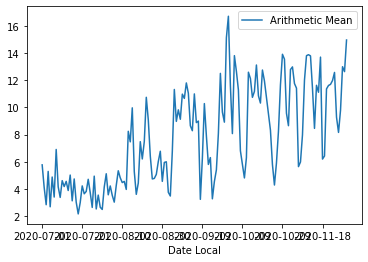

In [74]:
slim_no2[(slim_no2['fips'] == '06047') & (slim_no2['Date Local']>'2020-07-00')&(slim_no2['Date Local']<'2020-12-00')].plot(x="Date Local",y="Arithmetic Mean")

In [64]:
# y is for the FIPS 06047
y

,Date Local,Arithmetic Mean
19818,2020-09-11,11.808696
19835,2020-09-28,12.513043
19838,2020-10-01,15.142857
19839,2020-10-02,16.726087
19842,2020-10-05,13.821739
19843,2020-10-06,12.663636
19849,2020-10-12,12.600000
19850,2020-10-13,12.130435
19853,2020-10-16,13.130435
19856,2020-10-19,12.760870


The peak times from the above show an increase during the fall/winter months, I would be fine comparing trends into and out of this time period

### Now we can cross check data

With the dict of list of dicts above we can take the key (fips) and the dates within to select the correct data from the covid19 repository and establish a window of effect

- Select fips & date from peak dates
    - Might want to select window of days surrounding the peak
- grab covid data for peak dates
    - will want days leading up to and trailing the peak dates


 

In [76]:
counties.keys()

dict_keys(['type', 'features'])